In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Faster RCNN')

In [ ]:
# Directories to image files and annotation folder
file_dir = '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES'
annotation_dir = '/content/gdrive/MyDrive/Colab Notebooks/GC-10/ANNOTATIONS'

In [ ]:
# Import required python basic packages
import os
import random
import numpy as np
import pandas as pd
import glob

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import opencv
import cv2

# XML library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchutils library
from torch.utils.data import DataLoader, random_split

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# inception resnet v2
import timm

# these are the helper libraries imported.
import engine
import transforms as T
import utils
from engine import train_one_epoch, evaluate

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
# Import dataset
# define the train and test file directories

class GC10Dataset(torch.utils.data.Dataset):
    def __init__(self, file_dir, annotation_dir, width, height, transforms=None):
        self.transforms = transforms
        self.file_dir = file_dir
        self.annotation_dir = annotation_dir
        self.width = width
        self.height = height

        # Get all images
        all_imgs = glob.glob(os.path.join(file_dir, '**/*.jpg'), recursive=True)

        # Filter images that have corresponding annotation XML files
        self.imgs = []
        for img in all_imgs:
            annot_filename = os.path.splitext(os.path.basename(img))[0] + '.xml'
            annot_file_path = os.path.join(self.annotation_dir, annot_filename)

            if os.path.exists(annot_file_path):
                self.imgs.append(img)  # Only add if annotation file exists
            # else:
                # print(f"Warning: Annotation file for {img} not found.")

        # classes
        self.classes = ['crescent_gap', 'crease', 'silk_spot', 'water_spot',
                        'welding_line', 'inclusion', 'oil_spot',
                        'waist folding', 'rolled_pit', 'punching_hole']

    def __getitem__(self, idx):
      img_name = self.imgs[idx]
      image_path = img_name

      # Read the image
      img = cv2.imread(image_path)
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
      img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
      img_res /= 255.0

      # Extract annotation filename from image name
      annot_filename = os.path.splitext(os.path.basename(img_name))[0] + '.xml'
      annot_file_path = os.path.join(self.annotation_dir, annot_filename)

      boxes = []
      labels = []
      tree = et.parse(annot_file_path)
      root = tree.getroot()

      # cv2 image gives size as height x width
      wt = img.shape[1]
      ht = img.shape[0]

      # Get the folder name to determine the label
      folder_name = os.path.basename(os.path.dirname(img_name))

      # Ensure the folder name corresponds to a class
      if folder_name in self.classes:
        folder_label = self.classes.index(folder_name)
      else:
        raise ValueError(f'Folder name {folder_name} not recognized as a valid class.')

      # box coordinates for xml files are extracted and corrected for image size given
      for member in root.findall('object'):
          # bounding box
          xmin = int(member.find('bndbox').find('xmin').text)
          xmax = int(member.find('bndbox').find('xmax').text)
          ymin = int(member.find('bndbox').find('ymin').text)
          ymax = int(member.find('bndbox').find('ymax').text)

          # Scale bounding boxes to resized image dimensions
          xmin_corr = (xmin / wt) * self.width
          xmax_corr = (xmax / wt) * self.width
          ymin_corr = (ymin / ht) * self.height
          ymax_corr = (ymax / ht) * self.height

          if xmax_corr > xmin_corr + 1 and ymax_corr > ymin_corr + 1:
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
            labels.append(folder_label)
          else:
            print(f"Warning: Invalid box detected: [{xmin_corr}, {ymin_corr}, {xmax_corr}, {ymax_corr}]. Skipping.")

      # Convert boxes into a torch.Tensor
      boxes = torch.as_tensor(boxes, dtype=torch.float32)

      # Get areas of the boxes
      if boxes.dim() == 2:  # If boxes has 2 dimensions (rows and columns)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
      else:  # If boxes is empty or 1-dimensional
        area = torch.tensor([], dtype=torch.float32)  # Create an empty tensor for area


      # Suppose all instances are not crowd
      iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

      labels = torch.as_tensor(labels, dtype=torch.int64)

      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["area"] = area
      target["iscrowd"] = iscrowd

      # image_id
      # image_id = torch.tensor([idx])
      target["image_id"] = idx


      if self.transforms:
          # Apply transformations
          sample = self.transforms(image=img_res, bboxes=target['boxes'].tolist(),
                                   labels=target['labels'].numpy())
          img_res = sample['image']
          target['boxes'] = torch.Tensor(sample['bboxes'])

        # Convert img_res from [H, W, C] to [C, H, W] after transformation
        # img_res = img_res.permute(2, 0, 1)  # Convert to [C, H, W] for PyTorch

      return img_res, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
# Visualization
def plot_img_bbox(img, targets):
    index_to_class = {i: cls for i, cls in enumerate(['crescent_gap', 'crease', 'silk_spot', 'water_spot', 'welding_line', 'inclusion',
                                                      'oil_spot', 'waist folding','rolled_pit', 'punching_hole'])}

    # Define a mapping from index to class name
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)

    class_names = []

    for box, label in zip(targets['boxes'], targets['labels']):
      x_min, y_min, x_max, y_max = box.cpu().numpy()  # Ensure box is on CPU for NumPy
      width, height = x_max - x_min, y_max - y_min

      # Create a rectangle patch
      rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
      a.add_patch(rect)

      # Add the class name to the title
      class_name = index_to_class[label.item()]
      class_names.append(class_name)

    title = ', '.join(set(class_names))
    plt.title(title, fontsize=12)
    plt.show()

length of dataset =  2280 

(224, 224, 3) 
 {'boxes': tensor([[198.7344,  61.1520, 212.2969,  96.9920]]), 'labels': tensor([3]), 'area': tensor([486.0800]), 'iscrowd': tensor([0]), 'image_id': 0}


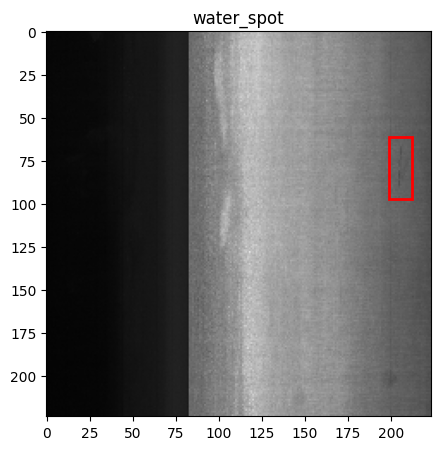

In [ ]:
# Call dataset without transforming
dataset = GC10Dataset(file_dir, annotation_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# Display a sample training image with its label
for img, target in dataset:
    print(img.shape, '\n',target)
    plot_img_bbox(img, target)
    # Break after showing one batch
    break

In [ ]:
def get_inception_resnet_v2_backbone(pretrained=True):
    # Load Inception ResNet v2
    model = timm.create_model('inception_resnet_v2', pretrained=pretrained, features_only=True)

    # Remove the classification head
    backbone = torch.nn.Sequential(*list(model.children())[:-1])
    backbone.out_channels = 2080

    # Add a reduction layer to adjust the output channels to 1536
    reduction_layer = nn.Conv2d(in_channels=2080, out_channels=1536, kernel_size=1)
    backbone = nn.Sequential(backbone, reduction_layer)
    backbone.out_channels = 1536

    return backbone

In [ ]:
# Define a model "fasterrcnn_inceptionresnetv2 pretrained"
from inceptionresnetv2 import inceptionresnetv2
import torch.nn as nn

def get_object_detection_model(num_classes):
    # load a model pre-trained pre-trained on COCO
    backbone = get_inception_resnet_v2_backbone(pretrained=True)
    # backbone = inceptionresnetv2(num_classes = num_classes, pretrained=None)
    # backbone.last_linear = nn.Linear(in_features=2080, out_features=num_classes, bias=True)
    # backbone.out_channels = backbone.last_linear.in_features
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5)
    model = FasterRCNN(
        backbone,
        num_classes=10,
        rpn_anchor_generator=anchor_generator)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):

    if train:
        return A.Compose([
                            # A.Resize(height=150, width=150),
                            # A.HorizontalFlip(0.5),
                            # A.VerticalFlip(0.5),
                            A.RandomBrightnessContrast(0.1),
                            A.ColorJitter(0.1),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
# use our dataset and defined transformations
dataset = GC10Dataset(file_dir, annotation_dir, 224, 224, transforms= get_transform(train=True))
dataset_test = GC10Dataset(file_dir, annotation_dir, 224, 224, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
images, targets = next(iter(data_loader))
images = list(image for image in images)
images = torch.stack(images)
    # Ensure images are in the format [N, C, H, W]
print("Original images shape:", images.shape)  # Should be [N, C, H, W]

Original images shape: torch.Size([4, 3, 150, 150])


In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 10
# get the model using our helper function
model = get_object_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

In [ ]:
# training for 30 epochs
num_epochs = 30
train_losses = []
val_accuracies = []
# start training
for epoch in range(num_epochs):
    # training for one epoch
    train_loss = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    train_losses.append(train_loss)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    val_accuracy = evaluate(model, data_loader_test, device=device)
    val_accuracies.append(val_accuracy)

Epoch: [0]  [  0/456]  eta: 1:36:02  lr: 0.000016  loss: 3.0625 (3.0625)  loss_classifier: 2.2973 (2.2973)  loss_box_reg: 0.0000 (0.0000)  loss_objectness: 0.6940 (0.6940)  loss_rpn_box_reg: 0.0712 (0.0712)  time: 12.6376  data: 8.3962  max mem: 7590
Epoch: [0]  [ 10/456]  eta: 0:22:00  lr: 0.000126  loss: 3.0625 (3.0770)  loss_classifier: 2.2953 (2.2945)  loss_box_reg: 0.0185 (0.0188)  loss_objectness: 0.6943 (0.6943)  loss_rpn_box_reg: 0.0712 (0.0694)  time: 2.9616  data: 1.3593  max mem: 8186
Epoch: [0]  [ 20/456]  eta: 0:18:03  lr: 0.000236  loss: 3.0602 (3.0858)  loss_classifier: 2.2884 (2.2859)  loss_box_reg: 0.0110 (0.0176)  loss_objectness: 0.6942 (0.6942)  loss_rpn_box_reg: 0.0421 (0.0881)  time: 1.9774  data: 0.6252  max mem: 8189
Epoch: [0]  [ 30/456]  eta: 0:15:13  lr: 0.000345  loss: 3.0446 (3.0688)  loss_classifier: 2.2566 (2.2688)  loss_box_reg: 0.0103 (0.0163)  loss_objectness: 0.6936 (0.6939)  loss_rpn_box_reg: 0.0765 (0.0898)  time: 1.6935  data: 0.3267  max mem: 8189

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

EXPECTED OUTPUT



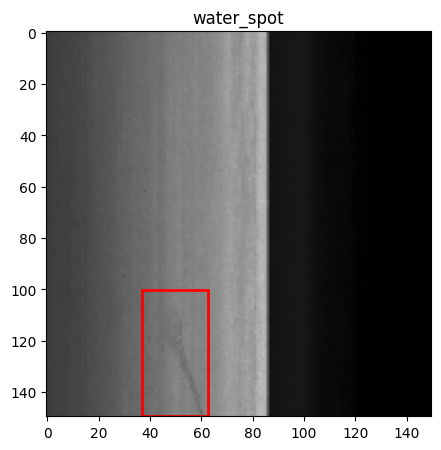

MODEL OUTPUT



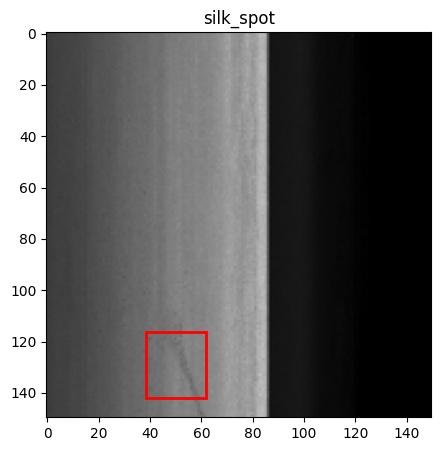

In [ ]:
dataset_test = GC10Dataset(file_dir, annotation_dir, 224, 224, transforms= get_transform(train=True))
# pick one image from the test set
img, target = dataset_test[35]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

In [ ]:
# Assuming `model` is your trained model
model_save_path = '/content/gdrive/MyDrive/Colab Notebooks/Faster RCNN/fasterrcnn_inception_resnet_v2_model_weights.pth'  # Specify the path and filename
torch.save(model.state_dict(), model_save_path)
print("Complete")

Complete
